# Imports

In [1]:
import os
import logging
import pandas as pd
import datetime
import numpy as np
import subprocess

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.pyplot import Polygon
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MinuteLocator
import matplotlib.ticker as ticker

import ipywidgets as widgets
from ipywidgets import interact

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.palettes import Spectral10

from IPython.display import Image

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts

try:
    from PT3S import Rm
except:
    import Rm

In [2]:
import importlib

In [3]:
importlib.reload(dxAndMxHelperFcts)

<module 'dxAndMxHelperFcts' from 'c:\\users\\wolters\\3s\\pt3s\\dxAndMxHelperFcts.py'>

# Logging

In [4]:
logger = logging.getLogger()  

logFileName= r"Example3.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Read Model and Results

In [5]:
dbFilename="DistrictHeating"
dbFile=os.path.join(os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))
                    +'/Examples/'
                    +dbFilename
                    +'.db3'
)

In [6]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile                                 
                                ,preventPklDump=True
                                #,maxRecords=-1
)

INFO    ; Dx.__init__: dbFile (abspath): c:\users\wolters\3s\pt3s\Examples\DistrictHeating.db3 exists readable ...
INFO    ; dxAndMxHelperFcts.readDxAndMx: 
+..\Examples\DistrictHeating.db3 is newer than
+..\Examples\WDDistrictHeating\B1\V0\BZ1\M-1-0-1.1.MX1:
+SIR 3S' dbFile is newer than SIR 3S' mx1File
+in this case the results are maybe dated or (worse) incompatible to the model
INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDDistrictHeating\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: DistrictHeating: processing dx and mx ...


In [7]:
m.V3_AGSN.shape,m.dfAGSN.shape

((537, 30), (528, 10))

# Longitudinal Sections

In [8]:
m.V3_AGSN

Pos                   pk                   tk LFDNR  \
ROHR 5691533564979419761  -1  5755933101669454049  5755933101669454049   1.0   
     5691533564979419761   0  5755933101669454049  5755933101669454049   1.0   
     5048873293262650113   1  5755933101669454049  5755933101669454049   1.0   
     5715081934973525403   2  5755933101669454049  5755933101669454049   1.0   
     5413647981880727734   3  5755933101669454049  5755933101669454049   1.0   
...                       ..                  ...                  ...   ...   
     4621030304810285220  39  4868980900521118307  4868980900521118307   3.0   
     5046251450517706156  40  4868980900521118307  4868980900521118307   3.0   
     5478012163155701568  41  4868980900521118307  4868980900521118307   3.0   
     4968402990875758821  42  4868980900521118307  4868980900521118307   3.0   
     4814824415166736381  43  4868980900521118307  4868980900521118307   3.0   

                                           NAME XL compNr  nextNODE  \
ROHR 5691533564979419761           Längsschnitt  0      1      V-E0   
     5691533564979419761           Längsschnitt  0      1  V-K1683S   
     5048873293262650113           Längsschnitt  0      1  V-K1693S   
     5715081934973525403           Längsschnitt  0      1  V-K2163S   
     5413647981880727734           Längsschnitt  0      1  V-K2043S   
...                                         ... ..    ...       ...   
     4621030304810285220  Längsschnitt in bar,B  2      1  R-K2583S   
     5046251450517706156  Längsschnitt in bar,B  2      1  R-K2593S   
     5478012163155701568  Längsschnitt in bar,B  2      1  R-K2603S   
     4968402990875758821  Längsschnitt in bar,B  2      1  R-K2613S   
     4814824415166736381  Längsschnitt in bar,B  2      1  R-K2623S   

                                  L         LSum  ...  \
ROHR 5691533564979419761   0.000000     0.000000  ...   
     5691533564979419761  15.351701    15.351701  ...   
     5048873293262650113  12.508947    27.860648  ...   
     5715081934973525403   6.265505    34.126153  ...   
     5413647981880727734  14.407541    48.533695  ...   
...                             ...          ...  ...   
     4621030304810285220   3.956838  1164.982003  ...   
     5046251450517706156  21.161676  1186.143680  ...   
     5478012163155701568  26.258772  1212.402452  ...   
     4968402990875758821  28.345589  1240.748040  ...   
     4814824415166736381  40.804501  1281.552541  ...   

                         ('STAT', 'KNOT~*~*~*~PH', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))_n  \
ROHR 5691533564979419761                                           4.800117                                                
     5691533564979419761                                           4.800117                                                
     5048873293262650113                                           4.731768                                                
     5715081934973525403                                           4.698539                                                
     5413647981880727734                                           4.629901                                                
...                                                                     ...                                                
     4621030304810285220                                           1.196312                                                
     5046251450517706156                                            1.09261                                                
     5478012163155701568                                           1.018315                                                
     4968402990875758821                                           0.911956                                                
     4814824415166736381                                           0.778286                                                

                         ('TIME', 'KN

In [9]:
dfAGSN=m.V3_AGSN[
    (m.V3_AGSN['LFDNR']==1)
    &
    (m.V3_AGSN['XL']==1)
]
dfAGSN

Pos                   pk                   tk LFDNR  \
ROHR 5691533564979419761  -1  5755933101669454049  5755933101669454049   1.0   
     5691533564979419761   0  5755933101669454049  5755933101669454049   1.0   
     5048873293262650113   1  5755933101669454049  5755933101669454049   1.0   
     5715081934973525403   2  5755933101669454049  5755933101669454049   1.0   
     5413647981880727734   3  5755933101669454049  5755933101669454049   1.0   
     5134010500800575790   4  5755933101669454049  5755933101669454049   1.0   
     4703401536268630837   5  5755933101669454049  5755933101669454049   1.0   
     4756919352045195395   6  5755933101669454049  5755933101669454049   1.0   
     4950699445422043390   7  5755933101669454049  5755933101669454049   1.0   
     5443612009555325057   8  5755933101669454049  5755933101669454049   1.0   
     5130272059781459965   9  5755933101669454049  5755933101669454049   1.0   
     5030450908543536722  10  5755933101669454049  5755933101669454049   1.0   
     5239323956327534825  11  5755933101669454049  5755933101669454049   1.0   
     4850985582584640333  12  5755933101669454049  5755933101669454049   1.0   
     5151949115143286654  13  5755933101669454049  5755933101669454049   1.0   
     5049850420107484598  14  5755933101669454049  5755933101669454049   1.0   
     5545006552869488471  15  5755933101669454049  5755933101669454049   1.0   
     4872083323315675215  16  5755933101669454049  5755933101669454049   1.0   
     5680559127926603859  17  5755933101669454049  5755933101669454049   1.0   
     5293317689029296733  18  5755933101669454049  5755933101669454049   1.0   
     5119633900217288954  19  5755933101669454049  5755933101669454049   1.0   
     4986912592668362327  20  5755933101669454049  5755933101669454049   1.0   
     5012186927559751405  21  5755933101669454049  5755933101669454049   1.0   
     5535463940319820632  22  5755933101669454049  5755933101669454049   1.0   
     4843836890906700052  23  5755933101669454049  5755933101669454049   1.0   
     4811306899232458618  24  5755933101669454049  5755933101669454049   1.0   
     4928779983564758026  25  5755933101669454049  5755933101669454049   1.0   
     4965578769510488820  26  5755933101669454049  5755933101669454049   1.0   
     5600841315591171772  27  5755933101669454049  5755933101669454049   1.0   
     4995034655758156710  28  5755933101669454049  5755933101669454049   1.0   
     5209057104414292468  29  5755933101669454049  5755933101669454049   1.0   
     5442010239090746007  30  5755933101669454049  5755933101669454049   1.0   
     4917786378639043296  31  5755933101669454049  5755933101669454049   1.0   
     4762482310382009633  32  5755933101669454049  5755933101669454049   1.0   
     4987229536643024523  33  5755933101669454049  5755933101669454049   1.0   
     5722206630503885118  34  5755933101669454049  5755933101669454049   1.0   
     5089459212485379804  35  5755933101669454049  5755933101669454049   1.0   
     5526871502288882655  36  5755933101669454049  5755933101669454049   1.0   
     4809089329099085219  37  5755933101669454049  5755933101669454049   1.0   
     5170001087020228683  38  5755933101669454049  5755933101669454049   1.0   
     5625716875961234775  39  5755933101669454049  5755933101669454049   1.0   
     5501916898830363065  40  5755933101669454049  5755933101669454049   1.0   
     5192970129555982907  41  5755933101669454049  5755933101669454049   1.0   
     5027225217797463802  42  5755933101669454049  5755933101669454049   1.0   
     5107343838750080243  43  5755933101669454049  5755933101669454049   1.0   

                                  NAME XL compNr  nextNODE          L  \
ROHR 5691533564979419761  Längsschnitt  1      1      V-E0   0.000000   
     5691533564979419761  Längsschnitt  1      1  V-K1683S  15.351701   
     5048873293262650113  Längsschnitt  1      1  V-K1693S  12.508947   
     5715081934973525403  Längsschnitt  1      1  V-

# Plot

## Define Axes

In [10]:
def fyP(ax,offset=0):
    ax.spines["left"].set_position(("outward", offset))
    ax.set_ylabel('Druck in bar')
    #ax.set_ylim(1,6)
    #ax.set_yticks(sorted(np.append(np.linspace(1,6,11),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')

def fyM(ax,offset=60):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('Massenstrom in t/h')
    #ax.set_ylim(500,550)
    #ax.set_yticks(sorted(np.append(np.linspace(500,550,11),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    
def fyT(ax,offset=120):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('Tempertatur in °C')
    #ax.set_ylim(85,95)
    #ax.set_yticks(sorted(np.append(np.linspace(0,95,11),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')

## Non-interactive Plot

In [11]:
def plot():
                       
    fig, ax0 = plt.subplots(figsize=Rm.DINA3q)
    
    ax0.set_yticks(np.linspace(0, 10, 21))
    ax0.yaxis.set_ticklabels([])
    ax0.grid()

    #P
    ax1 = ax0.twinx()     
    fyP(ax1) 
    ax1.plot(dfAGSN['LSum'], dfAGSN['PH_n'], color='red', label='P')
    
    #M
    ax2 = ax0.twinx()     
    fyM(ax2)
    ax2.step(dfAGSN['LSum'], dfAGSN['QM'], color='orange', label='T')
    
    #T
    ax3 = ax0.twinx() 
    fyT(ax3)
    ax3.plot(dfAGSN['LSum'], dfAGSN['T_n'], color='pink', label='M')
         
    ax0.set_title('Longitudinal Section for '+dbFilename)

    
    plt.show()

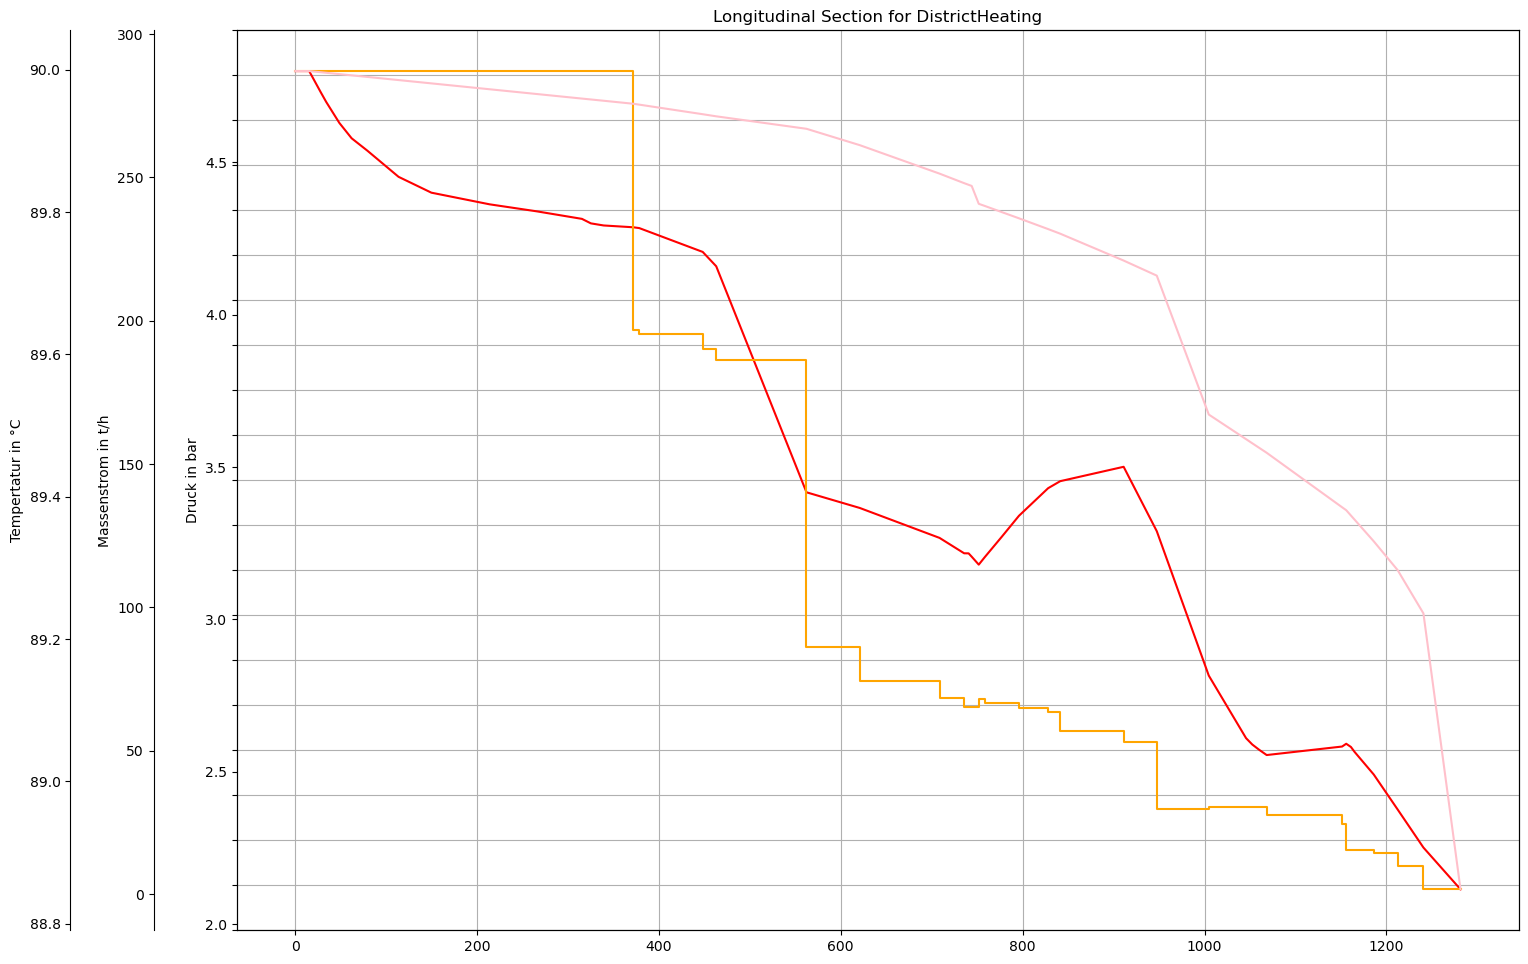

In [12]:
plot()